# Curto Circuito Autoencoder

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import random

import torch
from torch import nn, sigmoid
from torch.nn.modules.upsampling import Upsample
from torch.nn.functional import interpolate
from torch.autograd import Variable
from torch.nn import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Sigmoid, ReLU
# from Encoders import global_attention 

from torchsummary import summary

from google.colab import drive

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance

## Data

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
pathe = "/content/drive/MyDrive/DATA_BUS_68_ei/dataset_bus68_csv_estavel"
pathi = "/content/drive/MyDrive/DATA_BUS_68_ei/dataset_bus68_csv_instavel"

In [4]:
mypath_estavel = pathe
estavel_names = [f for f in listdir(mypath_estavel) if isfile(join(mypath_estavel, f))]

mypath_instavel = pathi
instavel_names = [f for f in listdir(mypath_instavel) if isfile(join(mypath_instavel, f))]

In [5]:
dataset_i, dataset_e = [], []

for name in tqdm(estavel_names):
    
    data = np.genfromtxt(mypath_estavel + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_e.append(data)

for name in tqdm(instavel_names):
    
    data = np.genfromtxt(mypath_instavel + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_i.append(data)


100%|██████████| 538/538 [02:05<00:00,  4.30it/s]


In [6]:
train_set, test_set = [], []

for counter, value in enumerate(dataset_e):
    
    if counter < 448:
        imagem = (value, 0)
        train_set.append(imagem)
    else:
        imagem = (value, 0)
        test_set.append(imagem)
    
for counter, value in enumerate(dataset_i):
    
    if counter < 448:
        imagem = (value, 1)
        train_set.append(imagem)
    else:
        imagem = (value, 1)
        test_set.append(imagem)


In [7]:
len(train_set)

896

In [8]:
por_train = (100*len(train_set))/(len(train_set)+len(test_set))
por_train

83.19405756731662

In [9]:
train_set[0]

(array([[[0.5      , 0.5      , 0.5      , ..., 0.5044425, 0.5041575,
          0.5042925],
         [0.5      , 0.5      , 0.5      , ..., 0.5045225, 0.504155 ,
          0.50422  ],
         [0.5      , 0.5      , 0.5      , ..., 0.504565 , 0.5040875,
          0.504065 ],
         ...,
         [0.5      , 0.5      , 0.5      , ..., 0.5045675, 0.5041925,
          0.5042375],
         [0.5      , 0.5      , 0.5      , ..., 0.5046725, 0.5041175,
          0.5040175],
         [0.5      , 0.5      , 0.5      , ..., 0.504715 , 0.504085 ,
          0.5039275]]]), 0)

In [10]:
random.shuffle(train_set)
random.shuffle(test_set)

## Trash

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        # ENCODER =============================
        
        self.conv1 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.batc1 = nn.BatchNorm2d(64)
        self.relu1 = ReLU()
        self.conv2 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc2 = nn.BatchNorm2d(128)
        self.relu2 = ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
            
        self.conv3 = Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc3 = nn.BatchNorm2d(128)
        self.relu3 = ReLU()
        self.conv4 = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc4 = nn.BatchNorm2d(256)
        self.relu4 = ReLU()
        self.pool2 = nn.MaxPool2d(3, 2)
            
        self.conv5 =  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc5 = nn.BatchNorm2d(256)
        self.relu5 = ReLU()
        self.conv6 = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc6 = nn.BatchNorm2d(512)
        self.relu6 = ReLU()
        self.conv7 = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc7 = nn.BatchNorm2d(512)
        self.relu7 = ReLU()
        
        # DECODER =============================
        
        self.conv8 = nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc8 = nn.BatchNorm2d(256)
        self.relu8 = ReLU()
        self.conv9 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.batc9 = nn.BatchNorm2d(128)
        self.relu9 = ReLU()
        # self.inter = Upsample(scale_factor=2, mode='nearest')

        self.conv10 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.batc10 = nn.BatchNorm2d(64)
        self.relu10 = ReLU()
        self.conv11 = nn.ConvTranspose2d(64, 64, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
        self.batc11 = nn.BatchNorm2d(64)
        self.relu11 = ReLU()
        self.conv12 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        
    def forward(self, x):
        x = self.relu1(self.batc1(self.conv1(x)))
        x = self.relu2(self.batc2(self.conv2(x)))

        x = self.pool1(x)
        
        x = self.relu3(self.batc3(self.conv3(x)))
        x = self.relu4(self.batc4(self.conv4(x)))
        x = self.pool2(x)
        
        x = self.relu5(self.batc5(self.conv5(x)))
        x = self.relu6(self.batc6(self.conv6(x)))
        x = self.relu7(self.batc7(self.conv7(x)))
        
        x = self.relu8(self.batc8(self.conv8(x)))
        x = self.relu9(self.batc9(self.conv9(x)))
        
        x = self.relu10(self.batc10(self.conv10(x)))
        x = self.relu11(self.batc11(self.conv11(x)))

        x = torch.sigmoid(self.conv12(x))
              
        return x




In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        # ENCODER =============================

        self.encoder = nn.Sequential(
          Conv2d(1, 64, kernel_size=(3, 4), stride=(1, 1), padding=0),
          nn.BatchNorm2d(64),
          ReLU(),
          Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(64),
          ReLU(),
          nn.MaxPool2d((2,3), 2),
              
          Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128),
          ReLU(),
          Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128),
          ReLU(),
          nn.MaxPool2d(3, 2),
              
          Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256),
          ReLU(),
          Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256),
          ReLU(),
          Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          ReLU(),

          Conv2d(256, 512, kernel_size=(3, 4), stride=(1, 2), padding=(1, 0)),
          nn.BatchNorm2d(512),
          ReLU(),
          Conv2d(512, 512, kernel_size=(3, 4), stride=(1, 2), padding=(1, 0)),
          ReLU(),
          nn.MaxPool2d(2, 2),
          Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0)),
          ReLU(),
          nn.MaxPool2d(2, 2)
        )
        
        
        
        # DECODER =============================
        
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(4),
            ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1)),
            nn.BatchNorm2d(4),
            ReLU(),

            nn.ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(2),
            ReLU(),
            nn.ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(1, 2), padding=(0, 14))

        )

        
    def forward(self, x):
      
        x = self.encoder(x)
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
              
        return x

## Model

In [11]:
classes = ['ESTAVEL', 'INSTAVEL']

In [12]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (0,1))) 

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=0)

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

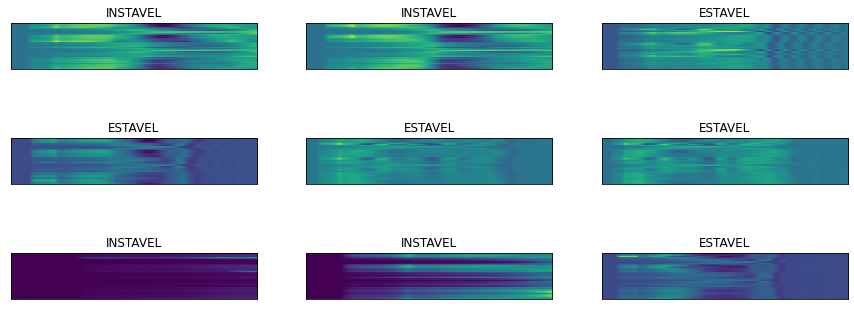

In [14]:
#Plot the images
fig = plt.figure(figsize=(15, 6))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx].squeeze())
    ax.set_title(classes[labels[idx]])

In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        # ENCODER =============================
        
        self.encoder = nn.Sequential(

            Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            ReLU(),
            Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),
            nn.MaxPool2d(2, 2),
                
            Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),
            Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            nn.MaxPool2d(3, 2),
                
            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            ReLU(),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            ReLU()

        )
        
        # DECODER =============================

        self.decoder = nn.Sequential(
        
            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        )

        
    def forward(self, x):
      
        x = self.encoder(x)
        
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
              
        return x

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = ConvAutoencoder()

device = get_device()
print(device)
model.to(device)

In [18]:
args = {'batch_size'   : 8,
        'lr'           : 0.01,
        'weight_decay' : 0.0005,
        'n_epochs'     : 100
        }

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args['batch_size'], num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=args['batch_size'], num_workers=0)

In [ ]:
criterion = nn.L1Loss().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
#Epochs
n_epochs = args['n_epochs']

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)


    if epoch % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} <- SAVE'.format(epoch, train_loss))
        torch.save(model.state_dict(), '/content/drive/MyDrive/MODEL_AUTOENCODER_D/conv_autoencoder_' + str(epoch) + '.pth')
    else:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

## Load

In [16]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = ConvAutoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_AUTOENCODER/conv_autoencoder_100.pth'))
model.eval()

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

## Test

Original Images


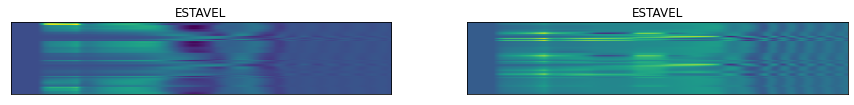

Reconstructed Images


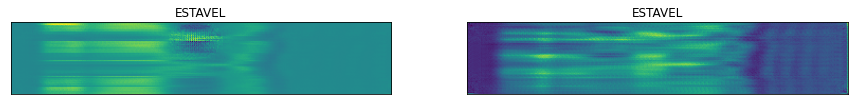

In [20]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.to(device)

#Sample outputs
output = model(images.float())

images = images.to("cpu")
images = images.numpy()

output = output.view(args['batch_size'], 1, 68, 360)
output = output.to("cpu")
output = output.detach().numpy()

"""
#Plot the images
fig = plt.figure(figsize=(15, 6))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
"""

k = 0
#Original Images
print("Original Images")
fig = plt.figure(figsize=(15,7))
for idx in np.arange(k, k+2):
    ax = fig.add_subplot(1, 2, idx+1-k, xticks=[], yticks=[])
    imshow(images[idx].squeeze())
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig = plt.figure(figsize=(15,7))
for idx in np.arange(k, k+2):
    ax = fig.add_subplot(1, 2, idx+1-k, xticks=[], yticks=[])
    imshow(output[idx].squeeze())
    ax.set_title(classes[labels[idx]])
plt.show() 

[]

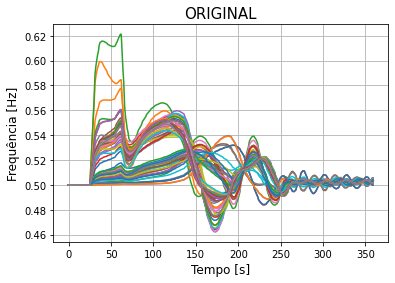

In [21]:
n = 0

carac = images[n].squeeze()
for i in range(0,68):

    plt.plot(carac[i])
    plt.title("ORIGINAL", fontsize=15)
    plt.xlabel("Tempo [s]", fontsize=12)
    plt.ylabel("Frequência [Hz]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

plt.plot()

[]

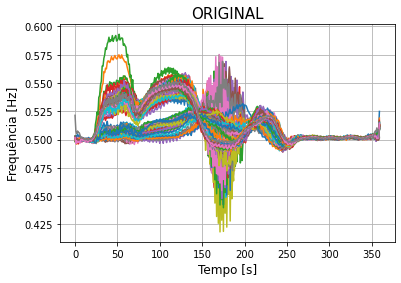

In [22]:
carac = output[n].squeeze()
for i in range(0,68):

    plt.plot(carac[i])
    plt.title("ORIGINAL", fontsize=15)
    plt.xlabel("Tempo [s]", fontsize=12)
    plt.ylabel("Frequência [Hz]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)

plt.plot()

In [23]:
n, x = 0, 10

carac1 = images[n].squeeze()
carac2 = output[n].squeeze()

for i in range(0,68):
    plt.plot(carac1[i])
    plt.plot(carac2[i])
    plt.title("REDE " + str(i), fontsize=15)
    plt.xlabel("Tempo [s]", fontsize=12)
    plt.ylabel("Frequência [Hz]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

0
Original Images


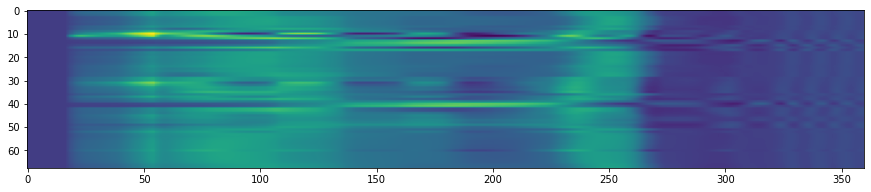

Reconstructed Images


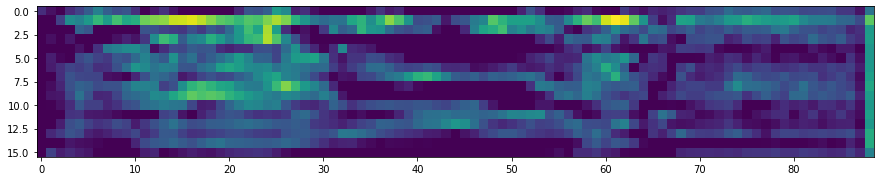

IndexError: ignored

In [32]:
a = 9
c = [train_set[a][0]]
print(train_set[a][1])
c = np.asarray(c)
c.shape

c = torch.from_numpy(c)
c = c.to(device)

output = model.encoder(c.float())
output = output.view(1, 512, 16, 89)
output = output.to("cpu")
output = output.detach().numpy()

print("Original Images")
fig = plt.figure(figsize=(15,9))
imshow(train_set[a][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show()

print('Reconstructed Images')
fig = plt.figure(figsize=(15,9))

imshow(output[0][0].squeeze())
ax.set_title(classes[labels[idx]])
plt.show() 

j = torch.mean(torch.from_numpy(output[1]), dim = (-2, -1))
print(j)

# SKT

In [34]:
def marsaglia(sphere_dim):
    '''Method to generate a point uniformly distributed on the (N-1) sphere by Marsaglia
    Args:
        sphere_dim (int): dimension of the sphere on which to generate the point
    '''
    norm_vals = np.random.standard_normal(sphere_dim)
    return norm_vals / np.linalg.norm(norm_vals)

In [24]:
class LocalAggregationLoss(nn.Module):
    '''Local Aggregation Loss module from "Local Aggregation for Unsupervised Learning of Visual Embeddings" by
    Zhuang, Zhai and Yamins (2019), arXiv:1903.12355v2
    '''
    def __init__(self, temperature,
                 k_nearest_neighbours, clustering_repeats, number_of_centroids,
                 memory_bank,
                 kmeans_n_init=1, nn_metric=cosine_distance, nn_metric_params={},
                 include_self_index=True, force_stacking=False):
        super(LocalAggregationLoss, self).__init__()

        self.temperature = temperature
        self.memory_bank = memory_bank
        self.include_self_index = include_self_index
        self.force_stacking = force_stacking

        self.background_neighbours = None
        self.close_neighbours = None

        self.neighbour_finder = NearestNeighbors(n_neighbors=k_nearest_neighbours + 1,
                                                 algorithm='ball_tree',
                                                 metric=nn_metric, metric_params=nn_metric_params)
        self.clusterer = []
        for k_clusterer in range(clustering_repeats):
            self.clusterer.append(KMeans(n_clusters=number_of_centroids,
                                         init='random', n_init=kmeans_n_init))

    def _nearest_neighbours(self, codes_data, indices):
        '''Ascertain indices in memory bank of the k-nearest neighbours to given codes
        Args:
            codes_data:
            indices:
        Returns:
            indices_nearest (numpy.ndarray): Boolean array of k-nearest neighbours for the batch of codes
        '''
        self.neighbour_finder.fit(self.memory_bank.vectors)
        indices_nearest = self.neighbour_finder.kneighbors(codes_data, return_distance=False)

        if not self.include_self_index:
            self_neighbour_masks = [np.where(indices_nearest[k] == indices[k]) for k in range(indices_nearest.shape[0])]
            if any([len(x) != 1 for x in self_neighbour_masks]):
                raise RuntimeError('Self neighbours not correctly shaped')
            indices_nearest = np.delete(indices_nearest, self_neighbour_masks, axis=1)

        return self.memory_bank.mask(indices_nearest)

    def _close_grouper(self, indices):
        '''Ascertain indices in memory bank of vectors that are in the same cluster as vectors of given indices
        Args:
            indices (numpy.ndarray):
        Returns:
            indices_close (numpy.ndarray): Boolean array of close neighbours for the batch of codes
        '''
        memberships = [[]] * len(indices)
        for clusterer in self.clusterer:
            clusterer.fit(self.memory_bank.vectors)
            for k_index, cluster_index in enumerate(clusterer.labels_[indices]):
                other_members = np.where(clusterer.labels_ == cluster_index)[0]
                other_members_union = np.union1d(memberships[k_index], other_members)
                memberships[k_index] = other_members_union.astype(int)

        return self.memory_bank.mask(np.array(memberships, dtype=object))

    def _intersecter(self, n1, n2):
        '''Compute set intersection of two boolean arrays
        Args:
            n1 (numpy array): Boolean array specifying a first selection of memory vectors
            n2 (numpy array): Boolean array specifying a second selection of memory vectors
        Returns:
            n1n2 (numpy array): Boolean array specifying the intersected selection of memory vectors of inputs
        '''
        ret = [[v1 and v2 for v1, v2 in zip(n1_x, n2_x)] for n1_x, n2_x in zip(n1, n2)]
        return np.array(ret)

    def _prob_density(self, codes, indices, force_stack=False):
        '''Compute the unnormalized probability density for the codes being in the sets defined by the indices
        The routine contains two ways to compute the densities, one where the batch dimension is handled using
        PyTorch function `bmm`, and one where the batch dimension is explicitly iterated over. The values obtained
        do not differ, but performance might. The former method is only possible if the subsets of data points are
        of identical size in the batch. If that is not true (the array is "ragged"), the iteration plus stacking
        is the only option.
        Args:
            codes
            indices
            force_stack (bool, optional): Even if the subsets are identical in size in the batch, compute densities
                with the iterate and stack method
        Returns:
            prob_dens (Tensor): The unnormalized probability density of the vectors with given codes being part
                of the subset of codes specified by the indices. There is one dimension, the batch dimension
        '''
        ragged = len(set([np.count_nonzero(ind) for ind in indices])) != 1

        # In case the subsets of memory vectors are all of the same size, broadcasting can be used and the
        # batch dimension is handled concisely. This will always be true for the k-nearest neighbour density
        if not ragged and not force_stack:
            vals = torch.tensor([np.compress(ind, self.memory_bank.vectors, axis=0) for ind in indices],
                                requires_grad=False)
            v_dots = torch.matmul(vals, codes.unsqueeze(-1))
            exp_values = torch.exp(torch.div(v_dots, self.temperature))
            xx = torch.sum(exp_values, dim=1).squeeze(-1)

        # Broadcasting not possible if the subsets of memory vectors are of different size, so then manually loop
        # over the batch dimension and stack results
        else:
            xx_container = []
            for k_item in range(codes.size(0)):
                vals = torch.tensor(np.compress(indices[k_item], self.memory_bank.vectors, axis=0),
                                    requires_grad=False)
                v_dots_prime = torch.mv(vals, codes[k_item])
                exp_values_prime = torch.exp(torch.div(v_dots_prime, self.temperature))
                xx_prime = torch.sum(exp_values_prime, dim=0)
                xx_container.append(xx_prime)
            xx = torch.stack(xx_container, dim=0)

        return xx

    def forward(self, codes, indices):
        '''Forward pass for the local aggregation loss module
        Args:
            codes:
            indices:
        Returns:
            loss:
        '''
        assert codes.shape[0] == len(indices)

        codes = codes.type(torch.DoubleTensor)
        code_data = normalize(codes.detach().numpy(), axis=1)

        # Compute and collect arrays of indices that define the constants in the loss function. Note that
        # no gradients are computed for these data values in backward pass
        self.memory_bank.update_memory(code_data, indices)
        self.background_neighbours = self._nearest_neighbours(code_data, indices)
        self.close_neighbours = self._close_grouper(indices)
        self.neighbour_intersect = self._intersecter(self.background_neighbours, self.close_neighbours)

        # Compute the probability density for the codes given the constants of the memory bank
        v = F.normalize(codes, p=2, dim=1)
        d1 = self._prob_density(v, self.background_neighbours, self.force_stacking)
        d2 = self._prob_density(v, self.neighbour_intersect, self.force_stacking)
        loss_cluster = torch.sum(torch.log(d1) - torch.log(d2)) / codes.shape[0]

        return loss_cluster

In [25]:
class MemoryBank(object):
    '''Memory bank
    Args:
        n_vectors (int): Number of vectors the memory bank should hold
        dim_vector (int): Dimension of the vectors the memory bank should hold
        memory_mixing_rate (float, optional): Fraction of new vector to add to currently stored vector. The value
            should be between 0.0 and 1.0, the greater the value the more rapid the update. The mixing rate can be
            set during calling `update_memory`.
    '''
    def __init__(self, n_vectors, dim_vector, memory_mixing_rate=None):

        self.dim_vector = dim_vector
        self.vectors = np.array([marsaglia(dim_vector) for _ in range(n_vectors)])
        self.memory_mixing_rate = memory_mixing_rate
        self.mask_init = np.array([False] * n_vectors)

    def update_memory(self, vectors, index):
        '''Update the memory with new vectors
        Args:
            vectors (np.ndarray)
        '''
        if isinstance(index, int):
            self.vectors[index] = self._update_(vectors, self.vectors[index])

        elif isinstance(index, np.ndarray):
            for ind, vector in zip(index, vectors):
                self.vectors[ind] = self._update_(vector, self.vectors[ind])

        else:
            raise RuntimeError('Index must be of type integer or NumPy array, not {}'.format(type(index)))

    def mask(self, inds_int):
        '''Construct a Boolean mask given integer indices.
        The integer indices can be of different lengths, which complicate some operations. By converting the list
        of integers into several boolean vectors, the lengths are the same.
        Args:
            inds_int (numpy array): A nested array of arrays, each element an integer corresponding to a memory
                vector. The nested array can be comprised of arrays of different size, a so-called ragged array.
        Returns:
            inds_bool (numpy array): A matrix, each element a boolean defining if corresponding memory vector
                should be selected. This array can be used to select or compress the set of memory vectors.
        '''
        ret_mask = []
        for row in inds_int:
            row_mask = np.full(self.vectors.shape[0], False)
            row_mask[row.astype(int)] = True
            ret_mask.append(row_mask)

        return np.array(ret_mask)

    def _update_(self, vector_new, vector_recall):
        v_add = vector_new * self.memory_mixing_rate + vector_recall * (1.0 - self.memory_mixing_rate)
        return v_add / np.linalg.norm(v_add)

    def _verify_dim_(self, vector_new):
        if len(vector_new) != self.dim_vector:
            raise VectorUpdateError('Update vector of dimension size {}, '.format(len(vector_new)) + \
                                    'but memory of dimension size {}'.format(self.dim_vector))

In [26]:
class ClusterHardnessLoss(nn.Module):
    '''Cluster Hardness Loss function as described in equations 4-6 in 'Clustering with Deep Learning: Taxonomy
    and New Methods' by Aljalbout et al. (2018) at arXiv:1801-07648v2
    Args:
        cc_init (PyTorch Tensor): initial cluster centres against which hardness is computed
        batch_reduction (bool, optional): if the total KL divergence should be normalized by batch size.
            Defaults to True.
    Attributes:
        cluster_centres (PyTorch Parameter): the cluster centre vectors, which are parameters, hence possible
            to pass to an optimizer for optimization.
    '''
    def __init__(self, cc_init, batch_reduction=True):
        super(ClusterHardnessLoss, self).__init__()

        self.batch_reduction = batch_reduction

        # The cluster centres are set as parameters of the module, such that they can be easily optimized.
        self.cluster_centres = nn.parameter.Parameter(cc_init)

    def forward(self, codes):
        '''Forward pass method for the cluster hardness loss
        Args:
            codes (PyTorch Tensor): codes for a mini-batch of objects, typically obtained from a trainable encoder.
                Dimensions should be (B, D) where B is size of batch, D is the dimension of the code
        Returns:
            loss : The cluster hardness loss that can be back-propagated.
        '''

        # Numerator for qij (equation 4)
        codes = codes.view(codes.shape[0], -1)
        dists = torch.square(torch.cdist(codes.unsqueeze(0), self.cluster_centres.unsqueeze(0))).squeeze()
        t1 = torch.div(torch.ones(dists.shape), torch.ones(dists.shape) + dists)

        # Denominator for qij (equation 4)
        t1_sum = torch.sum(t1, dim=1).repeat((t1.shape[1], 1)).permute((1, 0))

        # The similarity between points and cluster centroids
        qij = torch.div(t1, t1_sum)

        # Numerator for pij (equation 5)
        t2_sum1 = torch.sum(qij, dim=0).repeat((qij.shape[0], 1))
        t2 = torch.div(torch.square(qij), t2_sum1)

        # Denominator for pij (equation 5)
        t2_2 = torch.sum(t2, dim=1).repeat((t2.shape[1], 1)).permute((1, 0))

        # The target distribution for cluster hardness
        pij = torch.div(t2, t2_2)

        # Compute the KL divergence. This is preferred over using the kl_div functional since it lacks backward
        kl_div = (pij * (pij.log() - qij.log())).sum()

        if self.batch_reduction:
            kl_div = kl_div / codes.size()[0]

        return kl_div

    def update_cluster_centres_(self, c_new):
        '''Manually update the cluster centres
        '''
        if c_new.shape != self.cluster_centres.shape:
            raise ValueError('The dimension of new cluster centres {}, '.format(c_new.shape) + \
                             'not identical to dimension of old cluster centres {}'.format(self.cluster_centres.shape))
        self.cluster_centres.data = c_new.data

In [37]:
# Instantiate custom-made model and criterion with initial memory bank from pre-trained VGG-Encoder

memory_bank = MemoryBank(n_vectors=896, dim_vector=512, memory_mixing_rate=0.5)
# memory_bank.vectors = normalize(model.eval_codes_for_(train_loader), axis=1)
criterion = LocalAggregationLoss(memory_bank=memory_bank,
                                 temperature=0.07, k_nearest_neighbours=500, clustering_repeats=6, number_of_centroids=100)

# Instantiate a stochastic-gradient descent optimizer 
optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Rudimentary outline of training loop
for epoch in range(20):
    for inputs in train_loader:

        images, _ = inputs
        images = images.to(device)

        optimizer.zero_grad()
        output = model.encoder(images.float())
        output = torch.mean(torch.from_numpy(output[0]), dim = (-2, -1))
        loss = criterion(output.float(), images.float())
        loss.backward()
        optimizer.step()

        print('\nLoss: {:.4f}'.format(loss))

 
        outputs = model(images.float())
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

TypeError: ignored

In [ ]:
n_epochs = 20
    '''Train model for set number of epochs
    Args:
            n_epochs (int): Number of epochs to train the model for
    '''
    self.model.train()
    for epoch in range(n_epochs):
        print('Epoch {}/{}...'.format(epoch, n_epochs - 1), file=self.inp_f_out)

        running_loss = 0.0
        n_instances = 0
        for inputs in self.dataloader:
            size_batch = inputs[self.dataset.returnkey.image].size(0)
            image = inputs[self.dataset.returnkey.image].to(self.device)
            idx = inputs[self.dataset.returnkey.idx].detach().numpy()

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # Compute loss
            output = self.model(image)
            loss = self.criterion(output, idx)

            # Back-propagate and optimize
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Update aggregates and reporting
            running_loss += loss.item() * size_batch
            if self.inp_show_batch_progress:
                n_instances += size_batch
                progress_bar(n_instances, self.dataset_size)

        running_loss = running_loss / self.dataset_size
        print('\nLoss: {:.4f}'.format(running_loss), file=self.inp_f_out)

        self.save_model(self.inp_save_tmp_name)